In [1]:
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from utils import preprocessing, transforms

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

csv_dir = Path("norlab-data")

In [3]:
X_cols = [[k for k, v in ch.items() if v] for ch in columns.values()]
X_cols = list(chain.from_iterable(X_cols))

# Get recordings
data = preprocessing.get_recordings(csv_dir, summary)
merged = preprocessing.merge_upsample(data, summary, mode="last")

terrains = sorted(merged.terrain.unique())

X = merged[X_cols].copy()
y = merged.terrain.copy()

sm = SMOTE()
scaler = StandardScaler().set_output(transform="pandas")

X_res, y_res = sm.fit_resample(X, y)
X_res = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.3)

In [4]:
runs = merged[["terrain", "run_idx"]].copy().drop_duplicates()
runs
# train_test_split(np.zeros(len(runs.terrain)), runs.terrain, stratify=runs.terrain)

,terrain,run_idx
0,ASPHALT,0
5186,ASPHALT,1
30816,ASPHALT,2
31766,ASPHALT,3
40550,ASPHALT,4
...,...,...
685742,SNOW,22
691835,SNOW,23
696152,SNOW,24
701299,SNOW,25


In [5]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=25)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=25, oob_score=True)

In [6]:
y_pred = rf_clf.predict(X_test)
print(rf_clf.score(X_test, y_test))

0.9642664568122532


Text(0.5, 1.0, 'Random Forest')

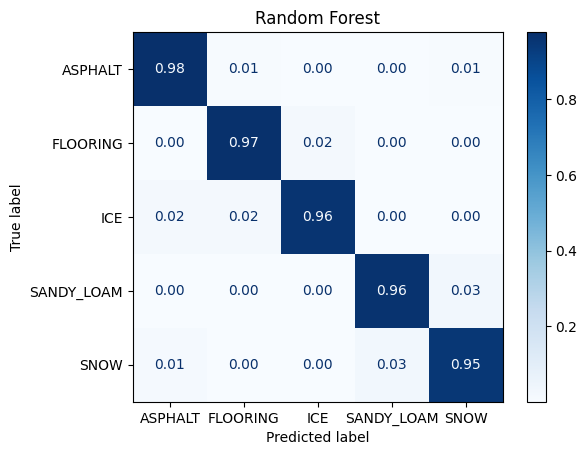

In [7]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=terrains,
    display_labels=terrains,
    normalize="true",
    values_format=".2f",
    cmap="Blues",
)
disp.ax_.set_title("Random Forest")

# ROC Curve

In [8]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_score = rf_clf.predict_proba(X_test)

[Text(0.5, 0, 'False Positive Rate'),
 Text(0, 0.5, 'True Positive Rate'),
 Text(0.5, 1.0, 'One-vs-Rest ROC')]

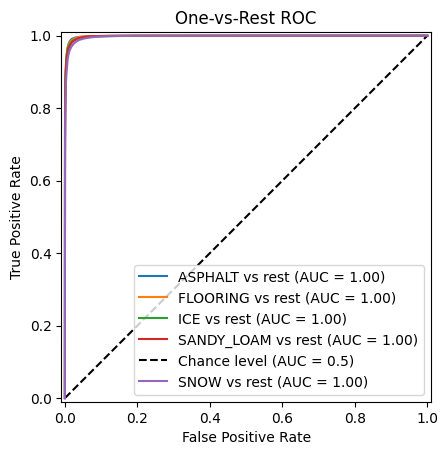

In [9]:
fig, ax = plt.subplots()
for clf_interest in terrains:
    class_id = np.flatnonzero(label_binarizer.classes_ == clf_interest)[0]
    disp = RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{clf_interest} vs rest",
        plot_chance_level=(class_id == 3),
        ax=ax,
    )
disp.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC",
)

# Power

In [10]:
power = merged[data["imu"].columns].copy()
power["P_motion"] = transforms.motion_power(merged)
power["HS"], power["HR"] = transforms.ssmr_power_model(merged)
X_cols = columns["imu"].keys()
X_cols = [*X_cols, "P_motion", "HS", "HR"]

In [11]:
X = power[X_cols].copy()
y = power.terrain.copy()

sm = SMOTE()
scaler = StandardScaler().set_output(transform="pandas")

X_res, y_res = sm.fit_resample(X, y)
X_res = scaler.fit_transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.3)

In [12]:
rf_clf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=25)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, n_jobs=25, oob_score=True)

In [13]:
y_pred = rf_clf.predict(X_test)
print(rf_clf.score(X_test, y_test))

0.9226511607572246


Text(0.5, 1.0, 'Random Forest with Power')

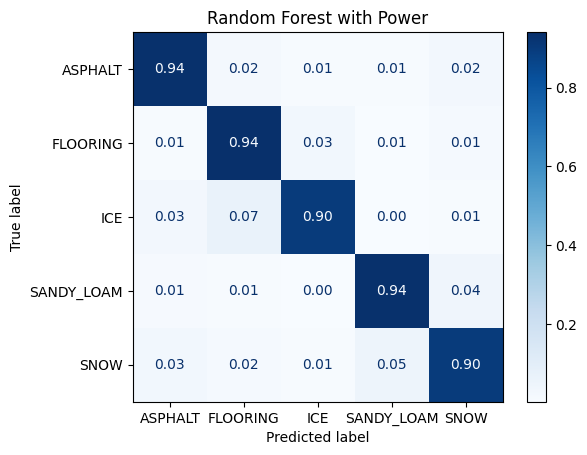

In [14]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    labels=terrains,
    display_labels=terrains,
    normalize="true",
    values_format=".2f",
    cmap="Blues",
)
disp.ax_.set_title("Random Forest with Power")